In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import seaborn as sns

In [52]:
df = pd.read_csv("/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [53]:
df.shape

(35887, 3)

<Axes: xlabel='emotion', ylabel='count'>

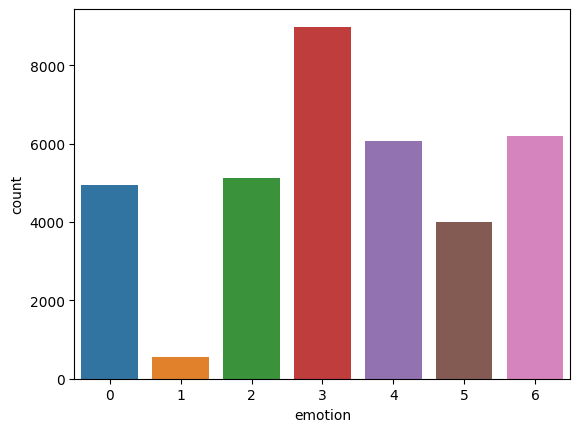

In [54]:
sns.countplot(x='emotion', data=df)

In [55]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

where  0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral and also we have only 547 image for Disgust Dataset

<Axes: xlabel=' Usage', ylabel='count'>

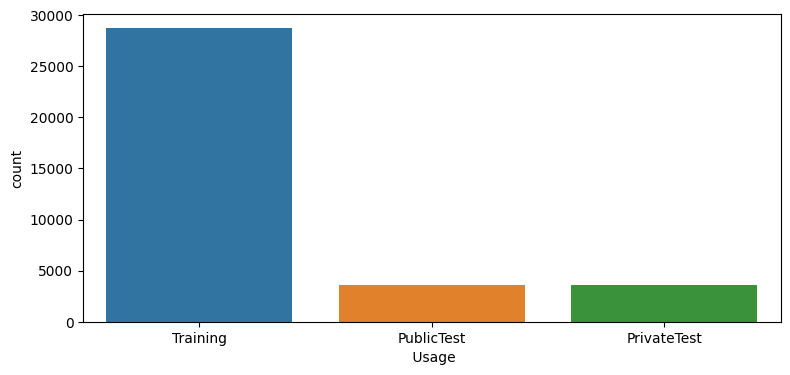

In [56]:
plt.figure(figsize=(9,4))
sns.countplot(x=' Usage', data=df)

In [57]:
import cv2
image_size=(48,48)

In [58]:
pixels = df[' pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(width, height)
  face = cv2.resize(face.astype('uint8'),image_size)
  faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = pd.get_dummies(df['emotion']).to_numpy()

In [59]:
x = faces.astype('float32')
x = x / 255.0
x = x - 0.5
x = x * 2.0
print(x.min(),x.max())
type(x)

-1.0 1.0


numpy.ndarray

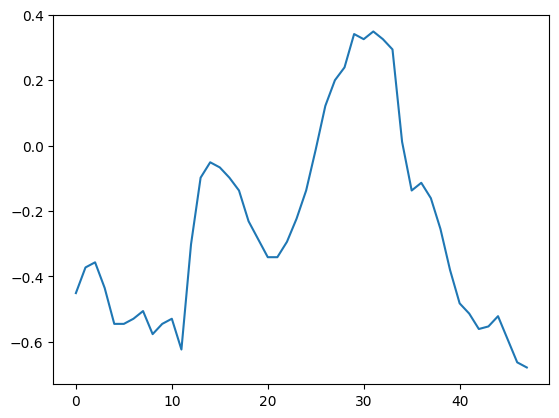

In [60]:
plt.plot(x[0,0])
plt.show()

In [61]:

train_x = x[:28709]
train_y = emotions[:28709]


val_x = x[28709:]
val_y = emotions[28709:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)


In [62]:
print('Training Pixels',train_x.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels',train_y.shape)

print('Validation Pixels',val_x.shape)
print('Validation labels',val_y.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709, 7)
Validation Pixels (7178, 48, 48, 1)
Validation labels (7178, 7)


In [63]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

In [64]:
input_shape=(48, 48, 1)
num_classes = 7

In [65]:
model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))



model.add(BatchNormalization())
model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax',name='predictions'))

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d_4 (Averag  (None, 24, 24, 16)      

In [67]:
batch_size = 32
num_epochs = 200
verbose = 1
num_classes = 7
patience = 50
base_path = 'drive/Colab Notebooks/emotion/simplecnn/'


In [68]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [69]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d_4 (Averag  (None, 24, 24, 16)      

In [71]:


datasets = ['icml_face_data']

num_epochs = 40
base_path="/content"
for dataset_name in datasets:
    print('Training dataset:', dataset_name)

    #callbacks
    log_file_path = dataset_name + '_emotion_training.log'

    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(patience/4), verbose=1)

    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
    my_callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

    train_faces, train_emotions = train_data
    history=model.fit_generator(data_generator.flow(train_faces, train_emotions,
                                            batch_size),
                        epochs=num_epochs, verbose=1
                        ,callbacks=my_callbacks,validation_data =val_data)

Training dataset: icml_face_data
Epoch 1/40


<ipython-input-71-4163ca27d124>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(data_generator.flow(train_faces, train_emotions,


896/898 [============================>.] - ETA: 0s - loss: 1.7769 - accuracy: 0.2855
Epoch 1: val_loss improved from inf to 1.67248, saving model to /contenticml_face_datasimple_cnn.01-1.67.hdf5
898/898 [==============================] - 30s 26ms/step - loss: 1.7768 - accuracy: 0.2856 - val_loss: 1.6725 - val_accuracy: 0.3722 - lr: 0.0010
Epoch 2/40
898/898 [==============================] - ETA: 0s - loss: 1.6386 - accuracy: 0.3543
Epoch 2: val_loss improved from 1.67248 to 1.49551, saving model to /contenticml_face_datasimple_cnn.02-1.50.hdf5
898/898 [==============================] - 23s 26ms/step - loss: 1.6386 - accuracy: 0.3543 - val_loss: 1.4955 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 3/40
896/898 [============================>.] - ETA: 0s - loss: 1.5813 - accuracy: 0.3801
Epoch 3: val_loss improved from 1.49551 to 1.48569, saving model to /contenticml_face_datasimple_cnn.03-1.49.hdf5
898/898 [==============================] - 24s 27ms/step - loss: 1.5815 - accuracy: 0.3799 - 

In [72]:
score = model.evaluate(val_x, val_y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

225/225 [==============================] - 1s 5ms/step - loss: 1.1225 - accuracy: 0.5706
Test loss: 1.1224840879440308
Test accuracy: 57.06325173377991


In [73]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [74]:
print(history_dict["accuracy"])

[0.28558987379074097, 0.3543139696121216, 0.379915714263916, 0.4018600583076477, 0.41976383328437805, 0.4288899004459381, 0.44212615489959717, 0.4543871283531189, 0.45842766761779785, 0.4672054052352905, 0.4716987609863281, 0.47870007157325745, 0.48395973443984985, 0.4840294122695923, 0.48584067821502686, 0.4915183484554291, 0.4934689402580261, 0.4956982135772705, 0.49636003375053406, 0.49987807869911194, 0.5021770000457764, 0.5016893744468689, 0.5035703182220459, 0.5069838762283325, 0.505973756313324, 0.5094221234321594, 0.5135323405265808, 0.5153087973594666, 0.5109199285507202, 0.5160054564476013, 0.515099823474884, 0.5193841457366943, 0.5165278911590576, 0.5204988121986389, 0.5191751718521118, 0.5191751718521118, 0.5236337184906006, 0.5233898758888245, 0.525061845779419, 0.5236337184906006]


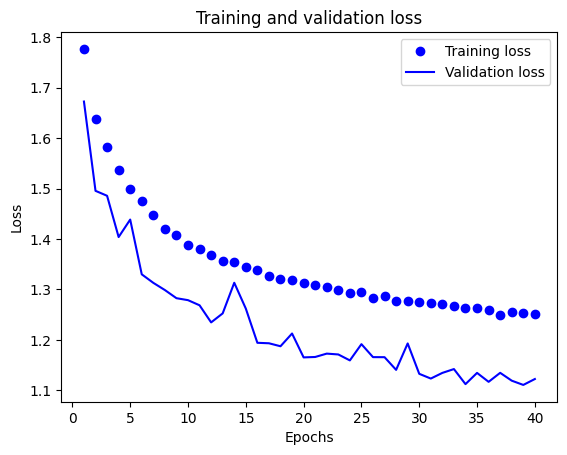

In [75]:
import matplotlib.pyplot as plt

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

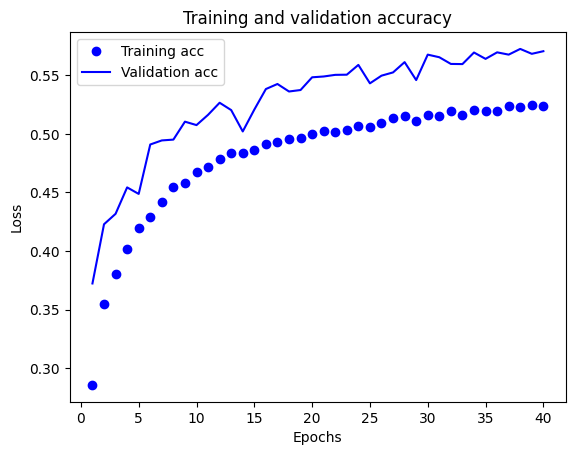

In [76]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
!pip install emoji --upgrade
import emoji


In [78]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}

emojis = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f641"}

In [79]:
print(emojis.values(),sep=" ")

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '🙁'])


In [93]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

def _predict(path):
  facecasc = cv2.CascadeClassifier('/content/drive/MyDrive/Facial-Emotion-Backend/haarcascade_frontalface_default.xml')
  imagePath = '/content/drive/MyDrive/Facial-Emotion-Backend/'+path
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
  print("No of faces : ",len(faces))
  i = 1
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)

    maxindex = int(np.argmax(prediction))
    print("person ",i," : ",emotion_dict[maxindex], "-->",emojis[maxindex])
    cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

  cv2_imshow(image)

No of faces :  1
1/1 [==============================] - 0s 307ms/step
person  1  :  Angry --> 😠


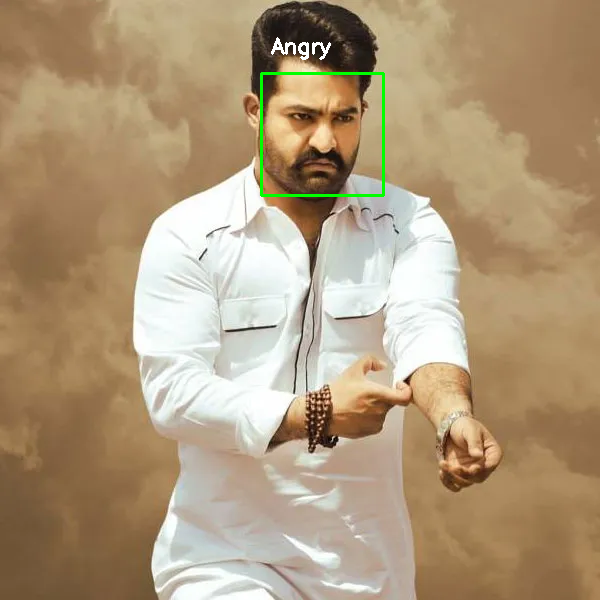

In [94]:
_predict('images/ntr.jpg')

No of faces :  1
1/1 [==============================] - 0s 35ms/step
person  1  :  Fearful --> 😨


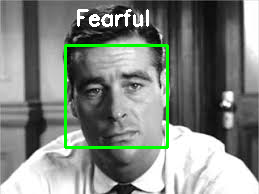

In [82]:
_predict('images/images (4).jpeg')

In [88]:
model.save_weights("model_weights.h5")

In [89]:
model.load_weights("model_weights.h5")

In [90]:
from keras.models import model_from_json

In [91]:
model_json = model.to_json()
with open("model_save.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
print("Saved model to disk")

# later...

# load json and create model
json_file = open('model_save.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights("model_weights.h5")


Saved model to disk


In [92]:
from google.colab import files
files.download("model_weights.h5")
files.download("model_save.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>